In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt

os.chdir('/home/bruno/datacloud')

plt.style.use('seaborn-dark')

plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (7.5, 5)

In [7]:
from theory.core import Pipe, Rock, TheoreticalWavelet, MultipleWavelets

from scipy import signal

from itertools import product

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from matplotlib.cm import get_cmap

cmap = get_cmap('bwr')

import matplotlib

100%|██████████| 44/44 [00:09<00:00,  5.12it/s]


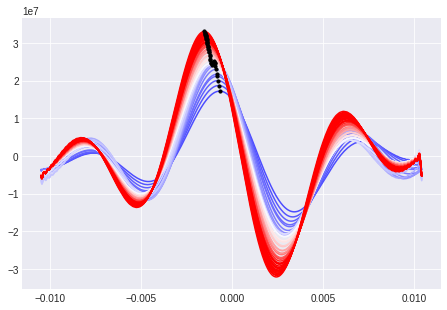

In [8]:
ax = plt.axes()
window = 210
alpha_range = np.arange(1000, 3000 + 200, 200)
rho_range = np.arange(1500, 2000 + 200, 200)

pipe = Pipe(Rb=0.16, alpha=4875, rho=7200)

for a, r in tqdm(product(alpha_range, rho_range), total=len(list(product(alpha_range, rho_range)))):
    mod = (r*(a**2)) * (1e-9)
    rock = Rock(alpha=a, beta=a, rho=r)

    theoretical = TheoreticalWavelet(pipe, rock, component='axial', nyquist=5000, filterby=[30,45,160,200])
    time_range = theoretical.get_time_range_for_window(window)/1000
    resampled_time = np.linspace(time_range.min(), time_range.max(), 100000)
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)                                    
    w += theoretical.pegleg_effect(delay_in_ms=1.50, RC=0.2392, window=None)
    
    w = np.gradient(w, theoretical.sampling_interval)

    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    w = theoretical.get_window_from_center(window, w)
    
    wavelet_full = signal.resample(w, 100000)
    delay = resampled_time[np.argmax(wavelet_full)]

    ax.plot(resampled_time, wavelet_full, color=cmap((mod-0)/10), zorder=5)
    ax.scatter(resampled_time[np.argmax(wavelet_full)], wavelet_full[np.argmax(wavelet_full)], s=10, c='k', zorder=10)

In [33]:
theoretical = TheoreticalWavelet(pipe, rock, nyquist=5000)

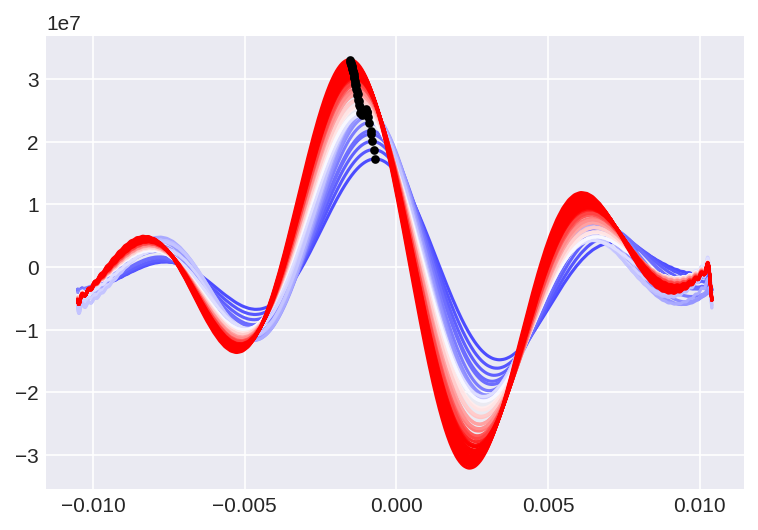

In [4]:
ax.figure.dpi = 150
ax.figure

In [5]:
alpha_range = np.arange(1000, 6000 + 200, 200)
rho_range = np.arange(1500, 4000 + 200, 200)

window = 210
axial_delays = []
axial_modulus = []

pipe = Pipe(Rb=0.16, alpha=4875, rho=7200)
wavelets = []
for a, r in tqdm(product(alpha_range, rho_range), total=len(list(product(alpha_range, rho_range)))):
    rock = Rock(alpha=a, beta=a, rho=r)
    theoretical = TheoreticalWavelet(pipe, rock, component='axial', nyquist=5000, filterby=[30,45,160,200])
    time_range = theoretical.get_time_range_for_window(window)/1000
    resampled_time = np.linspace(time_range.min(), time_range.max(), 100000)
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)                                    
    w += theoretical.pegleg_effect(delay_in_ms=1.5, RC=.2492, window=None)
    
    w = np.gradient(w, theoretical.sampling_interval)
    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    w = theoretical.get_window_from_center(window, w)
        
    wavelet_full = signal.resample(w, 100000)

    delay = resampled_time[np.argmax(wavelet_full)]
    axial_delays.append(delay)
    mod = (r*(a**2)) * (1e-9)
    axial_modulus.append(mod)
    
axial_delays = np.asarray(axial_delays)
# axial_delays = axial_delays + (0.0000001 - axial_delays.min())

axial_modulus = np.asarray(axial_modulus)

100%|██████████| 364/364 [02:07<00:00,  3.22it/s]


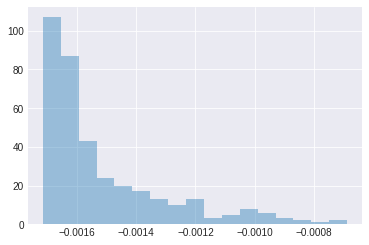

In [11]:
sns.distplot(axial_delays, label='axial_time', kde=False)

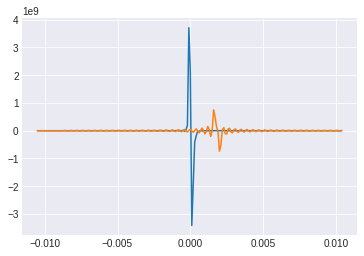

In [12]:
plt.plot(time_range, getattr(theoretical, 'primary_in_time_domain')(window=window, filtered=False))

plt.plot(time_range, theoretical.pegleg_effect(delay_in_ms=1.6, RC=.357, window=window))

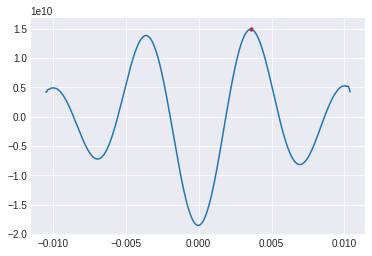

In [13]:
plt.plot(resampled_time, wavelet_full)

plt.scatter(resampled_time[np.argmax(wavelet_full)], wavelet_full[np.argmax(wavelet_full)], s=10, c='r')

In [14]:
window = 210
tangential_delays = []
tangential_modulus = []

beta_range = np.arange(300, 3500 + 200, 200)
rho_range = np.arange(1500, 4000 + 200, 200)

pipe = Pipe(Rb=0.16, alpha=4875, rho=7200)
wavelets = []
for b, r in tqdm(product(beta_range, rho_range), total=len(list(product(beta_range, rho_range)))):
    rock = Rock(beta=b, rho=r, component='tangential')
    theoretical = TheoreticalWavelet(pipe, rock, component='tangential', nyquist=5000, filterby=[30,45,160,200])
    time_range = theoretical.get_time_range_for_window(window)/1000
    resampled_time_full = np.linspace(time_range.min(), time_range.max(), 100000)
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)                                    
    w += theoretical.pegleg_effect(delay_in_ms=3.089, RC=-0.111, window=None)
    w = np.gradient(w, theoretical.sampling_interval)
    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    w = theoretical.get_window_from_center(window, w)
    
    wavelet_full = signal.resample(w, 100000)
    
#     # taking the zero crossing
#     resampled_time = resampled_time_full[int(wavelet_full.shape[0]/2):np.argmin(wavelet_full)]
#     wavelet = wavelet_full[int(wavelet_full.shape[0]/2):np.argmin(wavelet_full)]
    
#     idx = (np.abs(wavelet - 0)).argmin()
    
#     delay = resampled_time[idx]

    delay = resampled_time[np.argmax(wavelet_full)]
    
    tangential_delays.append(delay)
    mod = (r*(b**2)) * (1e-9)
    tangential_modulus.append(mod)
    
tangential_delays = np.asarray(tangential_delays)
# tangential_delays = tangential_delays + (0.0000001 - tangential_delays.min())

tangential_modulus = np.asarray(tangential_modulus)

100%|██████████| 238/238 [01:08<00:00,  3.77it/s]


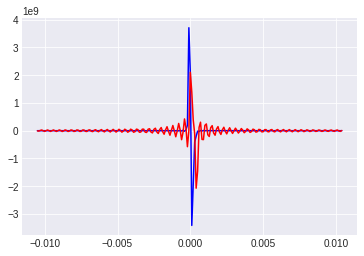

In [15]:
p = getattr(theoretical, 'primary_in_time_domain')(window=window, filtered=False)
r = getattr(theoretical, 'reflected_in_time_domain')(window=window, filtered=False)
m = getattr(theoretical, 'multiple_in_time_domain')(window=window, filtered=False)
plt.plot(time_range, p, color='b')
plt.plot(time_range, m, color='r')

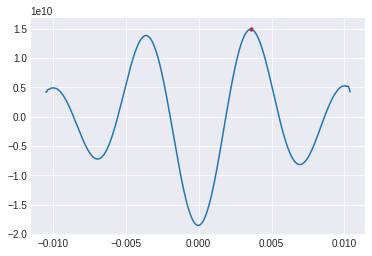

In [16]:
plt.plot(resampled_time_full, wavelet_full)
plt.scatter(resampled_time[np.argmax(wavelet_full)], wavelet_full[np.argmax(wavelet_full)], s=10, c='r')

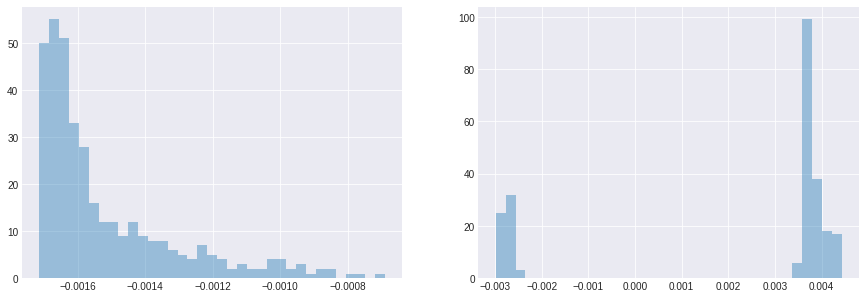

In [17]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(axial_delays, label='axial_time', ax=ax1, kde=False, bins=35)
sns.distplot(tangential_delays, label='tangential_time', ax=ax2, kde=False, bins=35)

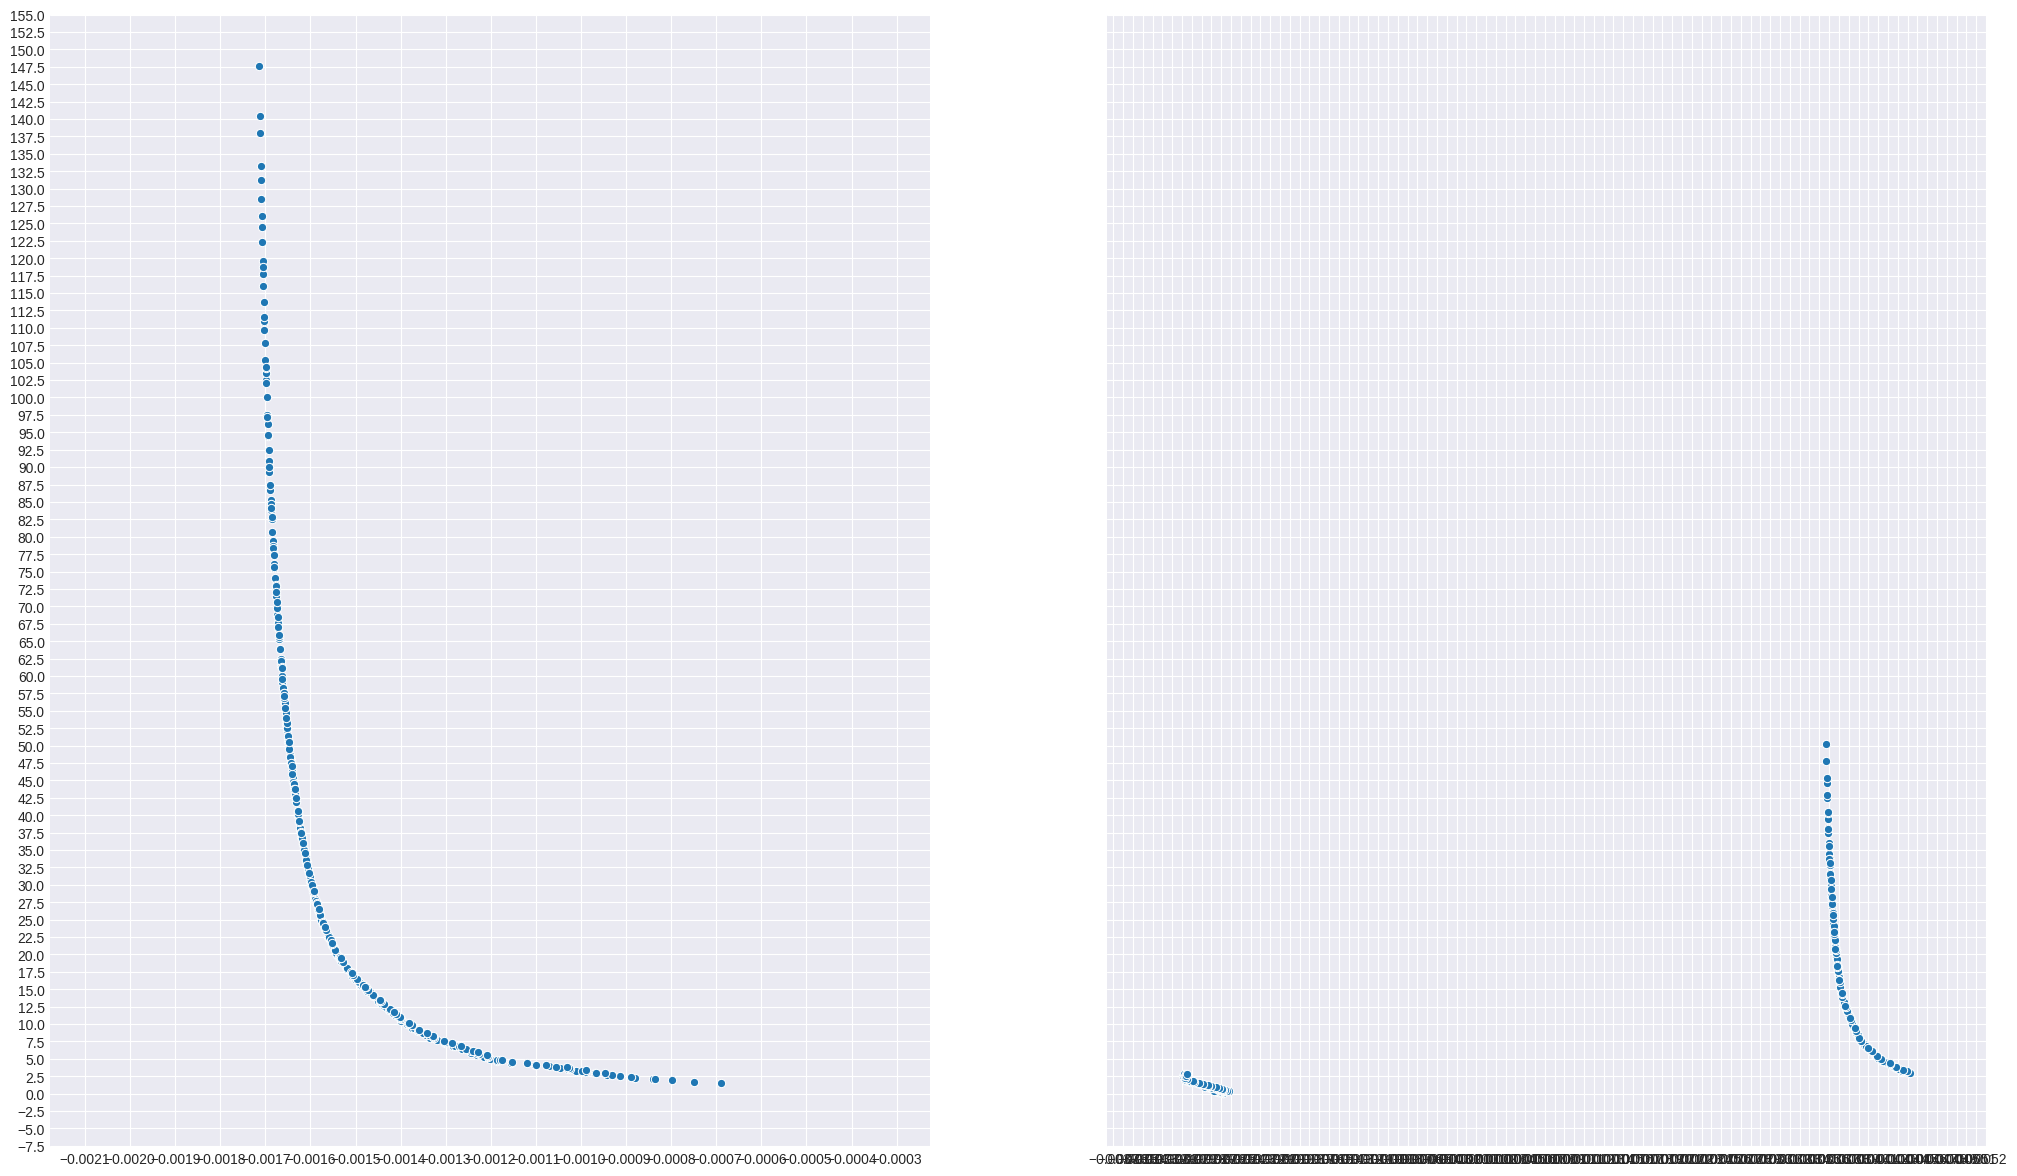

In [18]:
import matplotlib.ticker as ticker


fig, axes = plt.subplots(1, 2, figsize=(25,15), dpi=100, sharey=True)
sns.scatterplot(axial_delays, axial_modulus, ax=axes[0])
sns.scatterplot(tangential_delays, tangential_modulus, ax=axes[1])
for ax in axes.ravel():
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.0001))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

In [19]:
from scipy.optimize import curve_fit

def power_func(x, a, b):
    return a * (np.asarray(x)**b)

def power_func2(x, a, b, c, aa, bb):
    return ((a * (np.asarray(x)**b) + c) / (aa * np.asarray(x) + bb))

def power_func3(x, a, b, c, d, aa, bb, cc, e, ):
    return ((a * ((np.asarray(x)+b)**c) + d)/ (aa  * (np.asarray(x) ** 2) + bb * x + cc) * e)

def power_func4(x, a, b, c, d, aa, bb, e, ):
    return ((a * ((np.asarray(x)+b)**c) + d)  / (aa * np.asarray(x) + bb) * e)

def exponential_func(x, a, b, c):
    return a * np.exp(-b * np.asarray(x)) + c

def second_order_exponential_func(x, a, b, aa, bb, c):
    return a * np.exp(b * np.asarray(x)) + aa * (np.exp(bb * np.asarray(x)))**2 + c

In [20]:
current_axial_func = power_func3

In [21]:
current_tangential_func = power_func4

In [22]:
axial_const = curve_fit(current_axial_func, 
                        axial_delays[(axial_modulus) > 0],
                        axial_modulus[(axial_modulus) > 0], maxfev=1000000)[0].round(4)

In [23]:
tangential_const = curve_fit(current_tangential_func, 
                             tangential_delays[(tangential_modulus) > 3.5],
                             tangential_modulus[(tangential_modulus) > 3.5], 
                             maxfev=100000)[0]

In [24]:
axial_const

array([ 1.46680000e+00,  1.46610000e+00, -3.29060000e+02,  5.96800000e-01,
        1.07216871e+05,  4.15973100e+02,  3.99900000e-01,  4.68400000e-01])

In [25]:
axial_const

array([ 1.46680000e+00,  1.46610000e+00, -3.29060000e+02,  5.96800000e-01,
        1.07216871e+05,  4.15973100e+02,  3.99900000e-01,  4.68400000e-01])

In [26]:
'''({} * (x + {})^({}) + {}) / ({} * (x^2) + {} * x + {}) * {}'''.format(*axial_const.round(5))

'(1.4668 * (x + 1.4661)^(-329.06) + 0.5968) / (107216.8711 * (x^2) + 415.9731 * x + 0.3999) * 0.4684'

In [27]:
'''({} * (x + {})^({}) + {}) / ({} * x + {}) * {}'''.format(*tangential_const.round(5))

'(29.18407 * (x + 29.64091)^(-16822.93142) + 6.45474) / (7291.44698 * x + -25.5355) * 3.81016'

In [28]:
import matplotlib.ticker as ticker
import matplotlib

In [29]:
matplotlib.use('agg')

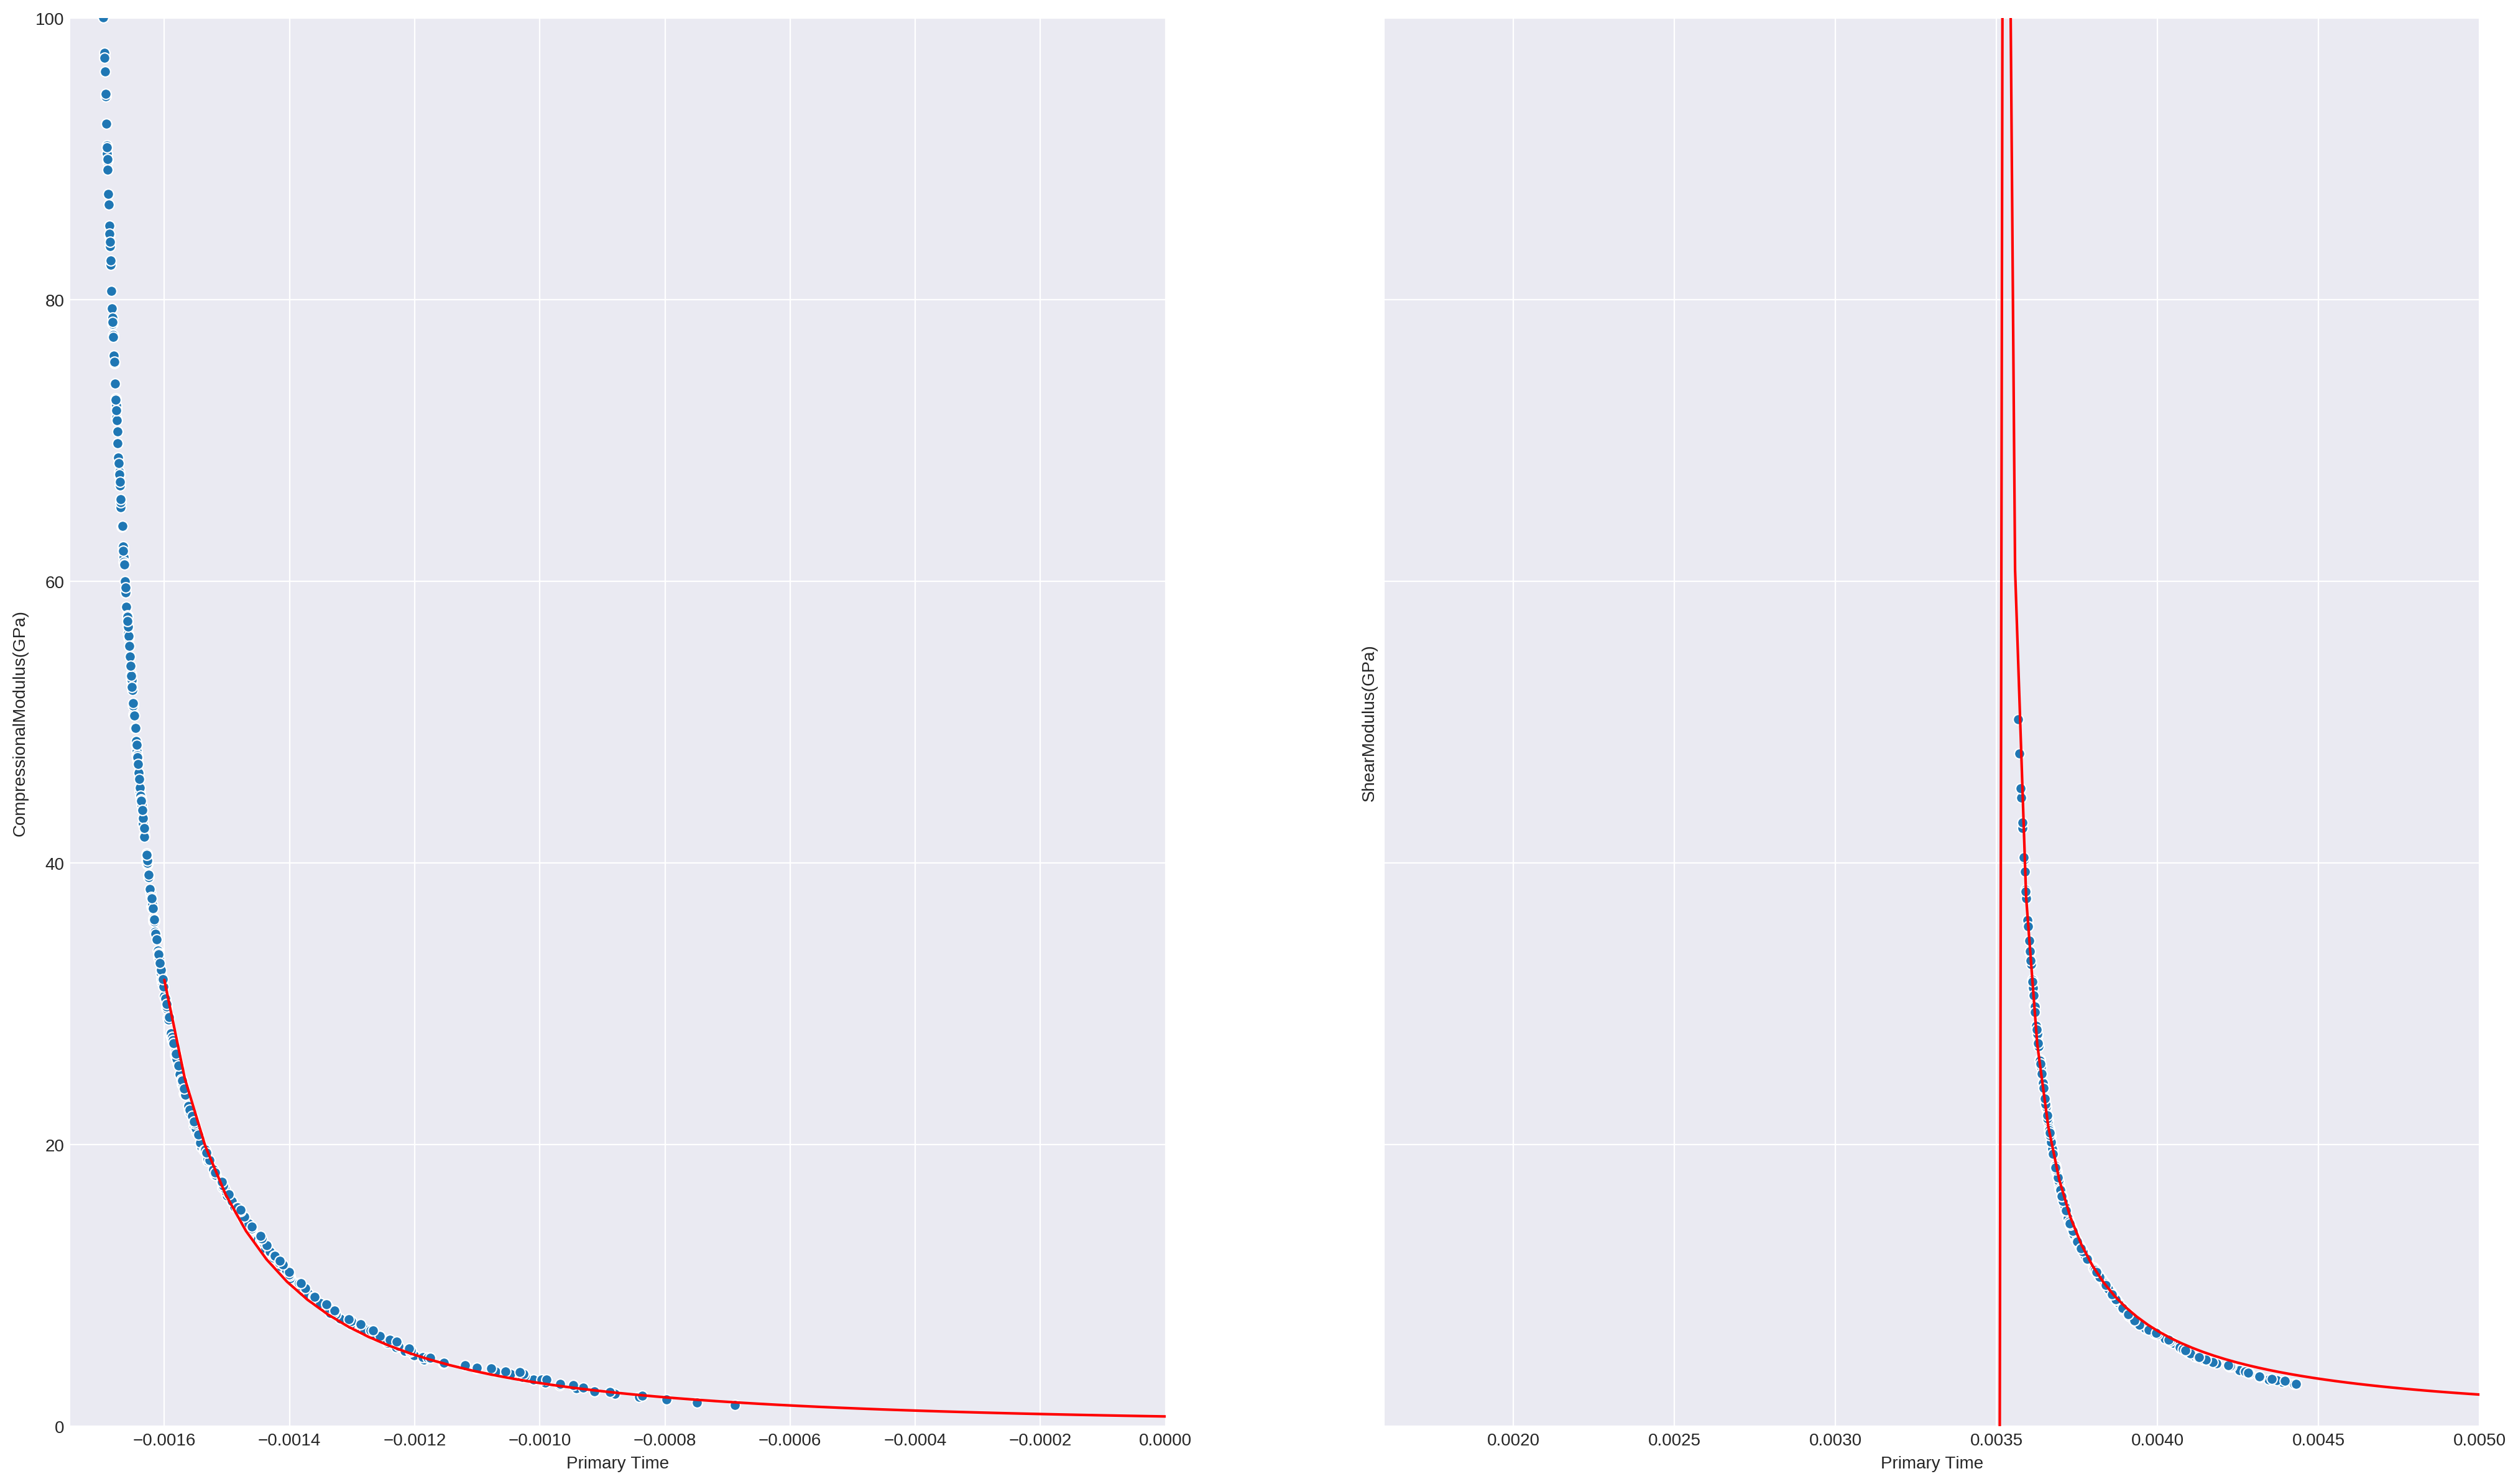

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(25,15), dpi=200, sharey=True)
sns.scatterplot(axial_delays, axial_modulus, ax=axes[0])
sns.scatterplot(tangential_delays, tangential_modulus, ax=axes[1])

axes[0].plot(np.linspace(-0.0016, 0.0), current_axial_func(np.linspace(-0.0016, 0.0), *axial_const.round(5)), '-', color='r')
axes[1].plot(np.linspace(0.0016, 0.005, 100), current_tangential_func(np.linspace(0.0016, 0.005, 100), *tangential_const.round(5)), '-', color='r')

axes[0].set_xlabel('Primary Time')
axes[0].set_ylabel('CompressionalModulus(GPa)')
axes[1].set_xlabel('Primary Time')
axes[1].set_ylabel('ShearModulus(GPa)')

axes[0].set_xlim(-0.00175, 0.0)
axes[1].set_xlim(0.0016, 0.005)

for ax in axes.ravel():
    ax.set_ylim(0, 100)

In [31]:
axial_lookup_table = pd.DataFrame(np.c_[np.asarray(list(product(alpha_range, rho_range))), axial_modulus, axial_delays], columns=['alpha', 'rho', 'modulus', 'modeled_delay'])
axial_lookup_table.to_csv('lp_projects/mt_wright/data/20190722-CompressionalModulus_LookupTable.csv', index=False)

In [32]:
tangential_lookup_table = pd.DataFrame(np.c_[np.asarray(list(product(beta_range, rho_range))), tangential_modulus, tangential_delays], columns=['beta', 'rho', 'modulus', 'modeled_delay'])
tangential_lookup_table = tangential_lookup_table.loc[tangential_lookup_table['modulus'] > 4]
tangential_lookup_table.to_csv('lp_projects/mt_wright/data/20190722-ShearModulus_LookupTable.csv', index=False)